In [1]:
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import os
import cv2
import math
import random
import numpy as np
from tqdm import tqdm
from pprint import pprint
random.seed(10)

## Initial Investigation

In [73]:
ORI_BASE_DIR = "F:\Minor Data Collection\Final Image Data\Monument Original"
AUG_BASE_DIR = os.path.join(ORI_BASE_DIR, 'Augmented Data')
annotation_path = 'Annotations'
jpg_image_path = 'JPEGImages'
ignore_list = ['kotilingeshvara', 'til mahadev narayan temple', 'king statue']
mistake_list = ['degutale temple', 'kritipur tower', 'degu tale']

In [74]:
def xml_to_df(path):
    xml_list = []
    class_name = ''
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            class_name = member[0].text
            if class_name not in ignore_list:
                if class_name in mistake_list:
                    if class_name == 'degutale temple' or class_name == 'degu tale':
                        class_name = 'degu tale temple_KDS'
                    elif class_name == 'kritipur tower':
                        class_name = 'kirtipur tower'
                value = (root.find('filename').text,
                         int(root.find('size')[0].text),
                         int(root.find('size')[1].text),
                         class_name,
                         int(member[4][0].text),
                         int(member[4][1].text),
                         int(member[4][2].text),
                         int(member[4][3].text)
                         )
                xml_list.append(value)
    column_name = ['class count', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    return pd.DataFrame(xml_list, columns=column_name)

In [143]:
# Analyzes XMLs in an annotation file and gives a bar chart 
def xml_to_bar_chart(path, count_thres = 100, print_plot = None):
    df = xml_to_df(path)
    class_dict = dict(df.groupby(['class']).count()['class count'].items())
    x_label = list()
    y_label = list()
    for key, value in class_dict.items():
        if value < count_thres and key not in ignore_list:
            x_label.append(key)
            y_label.append(value)
    plt.figure(figsize = (12, 7), dpi = 90)
    plt.bar(x_label, y_label, width = 0.9, color = 'dimgray')
    plt.xticks(rotation = 90)
    plt.yticks(np.arange(0, count_thres, 50))
    font = {'color': 'black', 'size': 16, 'weight': 'bold'}
    plt.xlabel('Monument Classes', fontdict = font)
    plt.ylabel('Classes Counts', fontdict = font)
    plt.axhline(y = 600, color = 'b', linestyle = '--')
    plt.axhline(y = 900, color = 'r', linestyle = '--')
    plt.title('Augmented Dataset', fontdict=font)
    if print_plot is not None:
        save_loc = os.path.join('Jpgs', print_plot + '.jpg')
        plt.savefig(save_loc, dpi = 240, bbox_inches = 'tight', pad_inches = 0.2)
    plt.show()

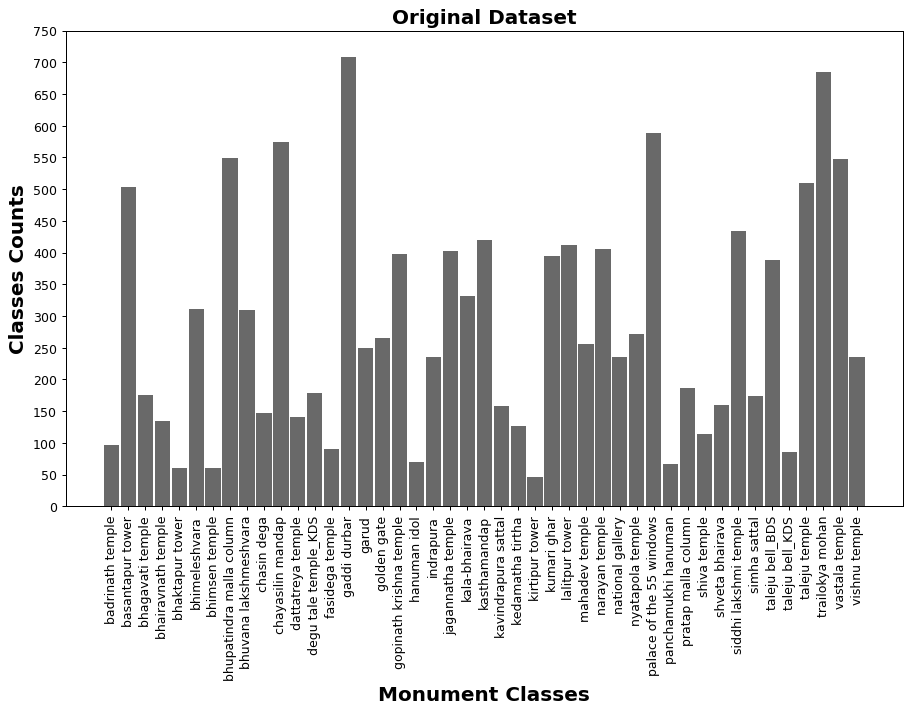

In [138]:
xml_to_bar_chart(r"F:\Minor Data Collection\Final Image Data\Monument Original\Annotations", 800, 'Original Dataset')

In [65]:
# Analyzes XMLs in an annotation file and gives 'class name list' & 'class [key:value] pair dictioary'
def lower_class_dict(path, count_thres = 100):
    df = xml_to_df(path)
    _dict = dict(df.groupby(['class']).count()['class count'].items())
    class_list = list()
    class_dict = dict()
    for key, value in _dict.items():
        if value < count_thres:
            class_list.append(key)
            class_dict[key] = value
    return class_list, class_dict 

In [76]:
def analyze_annotations_file(path, count_thres = 70, plot = False):
    ls, dt = lower_class_dict(path, count_thres)
    overall_dict = {}
    for monument_class in ls:
        xml_list = []
        filenames_list = []
        class_name = ''
        for xml_file in glob.glob(os.path.join(ORI_BASE_DIR, annotation_path) + '/*.xml'):
            contained_file = False
            tree = ET.parse(xml_file)
            root = tree.getroot()
            for member in root.findall('object'):
                class_name = member[0].text
                if class_name == monument_class:
                    contained_file = True
            if contained_file:
                filenames_list.append(xml_file.split('.')[0].split('\\')[-1])
                for member in root.findall('object'):
                    class_name = member[0].text
                    if class_name not in ignore_list:
                        if class_name in mistake_list:
                            if class_name == 'degutale temple' or class_name == 'degu tale':
                                class_name = 'degu tale temple_KDS'
                            elif class_name == 'kritipur tower':
                                class_name = 'kirtipur tower'
                        value = (root.find('filename').text,
                                 int(root.find('size')[0].text),
                                 int(root.find('size')[1].text),
                                 class_name,
                                 int(member[4][0].text),
                                 int(member[4][1].text),
                                 int(member[4][2].text),
                                 int(member[4][3].text)
                                 )
                        xml_list.append(value)
        column_name = ['class count', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
        df = pd.DataFrame(xml_list, columns=column_name)
        class_dict = dict(df.groupby(['class']).count()['class count'].items())
        x_label = list()
        y_label = list()
        for key, value in class_dict.items():
            x_label.append(key)
            y_label.append(value)
        if plot:
            plt.figure(figsize = (6, 3), dpi = 90)
            plt.bar(x_label, y_label, width = 0.9)
            plt.xticks(rotation = 90)
            plt.title(monument_class)
            plt.show()
        overall_dict[monument_class] = filenames_list
    return overall_dict

## Data Augmentation

In [77]:
# random hue and saturation

#iterate over the input directory
def random_hue_and_saturation(file_name, m_name, extra = None):
    # Load the image and its annotation
    image_path = os.path.join(ORI_BASE_DIR, jpg_image_path, file_name + '.jpg')
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Perform random hue and saturation augmentation
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_saturation(image, 0.3, 2)

    # Save the augmented image
    if extra is None:
        output_image_path = os.path.join(AUG_BASE_DIR, jpg_image_path, file_name + f'_HnS_{m_name}.jpg')
    else:
        output_image_path = os.path.join(AUG_BASE_DIR, jpg_image_path, file_name + f'_HnS_{m_name}_{extra}.jpg')
    tf.io.write_file(output_image_path, tf.image.encode_jpeg(image).numpy())

    # copy the annotation
    input_annotation_path = os.path.join(ORI_BASE_DIR, annotation_path, file_name + '.xml')
    if extra is None:
        output_annotation_path = os.path.join(AUG_BASE_DIR, annotation_path, file_name + f'_HnS_{m_name}.xml')
    else:
        output_annotation_path = os.path.join(AUG_BASE_DIR, annotation_path, file_name + f'_HnS_{m_name}_{extra}.xml')
    tree = ET.parse(input_annotation_path)
    root = tree.getroot()
    tree.write(output_annotation_path)

In [78]:
def random_brightness_and_contrast(file_name, m_name, extra = None):
    '''
        input: takes list of input images .jpg names
    '''
    # Load the image and its annotation
    image_path = os.path.join(ORI_BASE_DIR, jpg_image_path, file_name + '.jpg')
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Perform random hue and saturation augmentation
    image = tf.image.random_brightness(image, 0.4)
    image = tf.image.random_contrast(image, 0.2, 0.6)

    # Save the augmented image
    if extra is None:
        output_image_path = os.path.join(AUG_BASE_DIR, jpg_image_path, file_name + f'_BnC_{m_name}.jpg')
    else:
        output_image_path = os.path.join(AUG_BASE_DIR, jpg_image_path, file_name + f'_BnC_{m_name}_{extra}.jpg')
    tf.io.write_file(output_image_path, tf.image.encode_jpeg(image).numpy())

    # copy the annotation
    input_annotation_path = os.path.join(ORI_BASE_DIR, annotation_path, file_name + '.xml')
    if extra is None:
        output_annotation_path = os.path.join(AUG_BASE_DIR, annotation_path, file_name + f'_BnC_{m_name}.xml')
    else:
        output_annotation_path = os.path.join(AUG_BASE_DIR, annotation_path, file_name + f'_BnC_{m_name}_{extra}.xml')
    tree = ET.parse(input_annotation_path)
    root = tree.getroot()
    tree.write(output_annotation_path)

In [79]:
def random_rotation(file_name, m_name, extra = None):
    # Load the image and its annotation
    image_path = os.path.join(ORI_BASE_DIR, jpg_image_path, file_name + '.jpg')
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    degree = random.choice(np.concatenate((np.arange(-16, -8, 0.2), np.arange(8, 16, 0.2))))
    angle = degree * math.pi / 180
    image = tfa.image.rotate(image, angle,"bilinear","nearest")

    # Read the annotation file
    input_annotation_path = os.path.join(ORI_BASE_DIR, annotation_path, file_name + '.xml')
    tree = ET.parse(input_annotation_path)
    root = tree.getroot()

    # Get the size of the image
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    # Perform the rotation on the bounding boxes
    for obj in root.iter("object"):
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        ymin = 300 - ymin
        ymax = 300 - ymax

        # Find the center of the bounding box
        center_x = 150
        center_y = 150

        # Calculate the new bounding box coordinates
        xmin_new = round(center_x + (xmin - center_x) * math.cos(angle) - (ymin - center_y) * math.sin(angle))
        ymin_new = round(center_y + (xmin - center_x) * math.sin(angle) + (ymin - center_y) * math.cos(angle))
        xmax_new = round(center_x + (xmax - center_x) * math.cos(angle) - (ymax - center_y) * math.sin(angle))
        ymax_new = round(center_y + (xmax - center_x) * math.sin(angle) + (ymax - center_y) * math.cos(angle))

        ymin_new = 300 - ymin_new
        ymax_new = 300 - ymax_new

        xmin1 = min([xmin_new,xmax_new])
        xmax1 = max([xmin_new,xmax_new])
        ymin1 = min([ymin_new,ymax_new])
        ymax1 = max([ymin_new,ymax_new])

        # calculate factors by which bounding box width might increase            
        width_reduce_factor = 0.8 - 0.02 * (degree - 10)
        reduced_width = width_reduce_factor * (xmax1 - xmin1)
        center_x = (xmax1 + xmin1) / 2

        xmin1 = round(center_x - reduced_width / 2)
        xmax1 = round(center_x + reduced_width / 2)

        reduced_height = (ymax - ymin)-(ymax1 - ymin1)
        ymin1 = round(ymin1 - reduced_height / 2)
        ymax1 = round(ymax1 + reduced_height / 2)
        
        # handles corner cases
        dim_arr = [ xmin1 , ymin1, xmax1, ymax1 ] 
        for y in range(0,4):
            i = dim_arr[y]
            i = i if i >= 0 else 0
            i = i if i <= 300 else 300
            dim_arr[y] = i

        xmin1 , ymin1, xmax1, ymax1 = dim_arr
    
        # Update the bounding box coordinates in the annotation file
        bndbox.find("xmin").text = str(xmin1)
        bndbox.find("ymin").text = str(ymin1)
        bndbox.find("xmax").text = str(xmax1)
        bndbox.find("ymax").text = str(ymax1)

    # Save the augmented image
    if extra is None:
        output_image_path = os.path.join(AUG_BASE_DIR, jpg_image_path, file_name + f'_RR_{m_name}.jpg')
    else:
        output_image_path = os.path.join(AUG_BASE_DIR, jpg_image_path, file_name + f'_RR_{m_name}_{extra}.jpg')
    tf.io.write_file(output_image_path, tf.image.encode_jpeg(image).numpy())

    # copy the annotation
    if extra is None:
        output_annotation_path = os.path.join(AUG_BASE_DIR, annotation_path, file_name + f'_RR_{m_name}.xml')
    else:
        output_annotation_path = os.path.join(AUG_BASE_DIR, annotation_path, file_name + f'_RR_{m_name}_{extra}.xml')
    tree.write(output_annotation_path)

In [80]:
def multiple_orient(file_name, m_name):
    # Load the image and its annotation
    image_path = os.path.join(ORI_BASE_DIR, jpg_image_path, file_name + '.jpg')
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Read the annotation file
    input_annotation_path = os.path.join(ORI_BASE_DIR, annotation_path, file_name + '.xml')
    tree = ET.parse(input_annotation_path)
    root = tree.getroot()

    # Get the size of the image
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    # Perform the rotation on the image
    orientations = [90,180,270]
    for orientation in orientations:
        factor = int(orientation / 90)
        image = tf.image.rot90(image, k=factor)
        angle = math.radians(orientation)

        # Perform the rotation on the bounding boxes
        for obj in root.iter("object"):
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = 300 - int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = 300 - int(bndbox.find("ymax").text)

            # Find the center of the bounding box
            center_x = 150
            center_y = 150

            # Calculate the new bounding box coordinates
            xmin_new = round(center_x + (xmin - center_x) * math.cos(angle) - (ymin - center_y) * math.sin(angle))
            ymin_new = round(center_y + (xmin - center_x) * math.sin(angle) + (ymin - center_y) * math.cos(angle))
            xmax_new = round(center_x + (xmax - center_x) * math.cos(angle) - (ymax - center_y) * math.sin(angle))
            ymax_new = round(center_y + (xmax - center_x) * math.sin(angle) + (ymax - center_y) * math.cos(angle))

            ymin_new = 300 - round(ymin_new)
            ymax_new = 300 - round(ymax_new)

            xmin1 = min([xmin_new,xmax_new])
            xmax1 = max([xmin_new,xmax_new])
            ymin1 = min([ymin_new,ymax_new])
            ymax1 = max([ymin_new,ymax_new])

            dim_arr = [ xmin1 , ymin1, xmax1, ymax1 ] 
            for y in range(0,4):
                i = dim_arr[y]
                i = i if i >= 0 else 0
                i = i if i <= 300 else 300
                dim_arr[y] = i

            xmin1 , ymin1, xmax1, ymax1 = dim_arr
            
            # Update the bounding box coordinates in the annotation file
            bndbox.find("xmin").text = str(xmin1)
            bndbox.find("ymin").text = str(ymin1)
            bndbox.find("xmax").text = str(xmax1)
            bndbox.find("ymax").text = str(ymax1)

        # Save the augmented image
        output_image_path = os.path.join(AUG_BASE_DIR, jpg_image_path, file_name + f'_MO_{orientation}_{m_name}.jpg')
        tf.io.write_file(output_image_path, tf.image.encode_jpeg(image).numpy())

        # copy the annotation
        output_annotation_path = os.path.join(AUG_BASE_DIR, annotation_path, file_name + f'_MO_{orientation}_{m_name}.xml')
        tree.write(output_annotation_path)

In [89]:
def random_translation(file_name, m_name = None, t_type = 0, extra = None):
    # Load the image and its annotation
    image_path = os.path.join(ORI_BASE_DIR, jpg_image_path, file_name + '.jpg')
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    dx_dy_list = [[30,0],[0,30],[-30,0],[0,-30],[30,30],[-30,-30],[-30,30],[30,-30]]
    dx_dy = dx_dy_list[t_type]
    # Perform translation augmentation
    image = tfa.image.translate(image, dx_dy,"bilinear","constant")

    # Read the annotation file
    input_annotation_path = os.path.join(ORI_BASE_DIR, annotation_path, file_name + '.xml')
    tree = ET.parse(input_annotation_path)
    root = tree.getroot()

    # Get the size of the image
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    # Perform the rotation on the bounding boxes
    remove = []
    for obj in root.iter("object"):
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        original_width = xmax-xmin
        original_height = ymax-ymin

        # xmin ymin xmax ymax
        dim_arr = [ xmin + dx_dy[0] , ymin + dx_dy[1] , xmax + dx_dy[0], ymax + dx_dy[1] ] 
        for y in range(0,4):
            i = dim_arr[y]
            i = i if i >= 0 else 0
            i = i if i <= 300 else 300
            dim_arr[y] = i

        xmin1 , ymin1, xmax1, ymax1 = dim_arr

        final_width = xmax1-xmin1
        final_height = ymax1-ymin1

        # if translated bbox does not retain 50% of it's original width and height then remove it
        if( (final_width/original_width) < 0.50 or (final_height/original_height)< 0.50):
            root.remove(obj)
            print("Im here")
        else:
            # Update the bounding box coordinates in the annotation file
            bndbox.find("xmin").text = str(xmin1)
            bndbox.find("ymin").text = str(ymin1)
            bndbox.find("xmax").text = str(xmax1)
            bndbox.find("ymax").text = str(ymax1)

    # Save the augmented image
    output_image_path = os.path.join(AUG_BASE_DIR, jpg_image_path, file_name + f'_TRAN_{t_type}_{m_name}.jpg')
    tf.io.write_file(output_image_path, tf.image.encode_jpeg(image).numpy())

    # copy the annotation
    output_annotation_path = os.path.join(AUG_BASE_DIR, annotation_path, file_name + f'_TRAN_{t_type}_{m_name}.xml')
    tree.write(output_annotation_path)

In [82]:
# ORI_ANNOTATION_PATH = os.path.join(ORI_BASE_DIR, annotation_path)
# for monument_class, augmentation_list in analyze_annotations_file(ORI_ANNOTATION_PATH).items():
#     for filename in tqdm(augmentation_list):
#         random_hue_and_saturation(filename, monument_class)
#         random_brightness_and_contrast(filename, monument_class)
#         random_rotation(filename, monument_class)
#         multiple_orient(filename, monument_class)

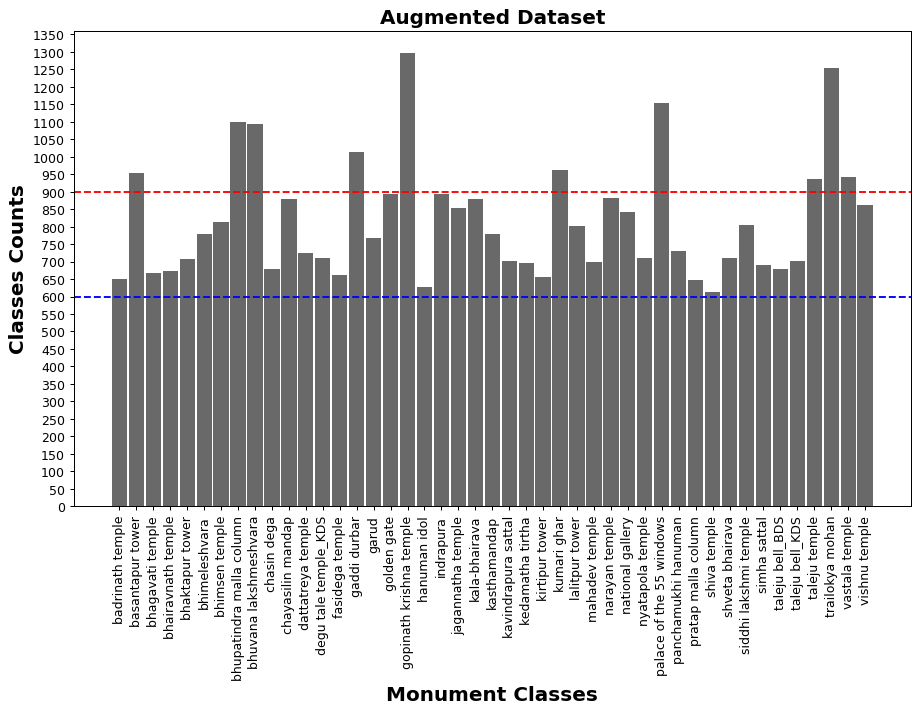

In [144]:
xml_to_bar_chart(os.path.join(ORI_BASE_DIR, 'Merged_Original_Augmented', annotation_path), 1400, 'Augmented Dataset')

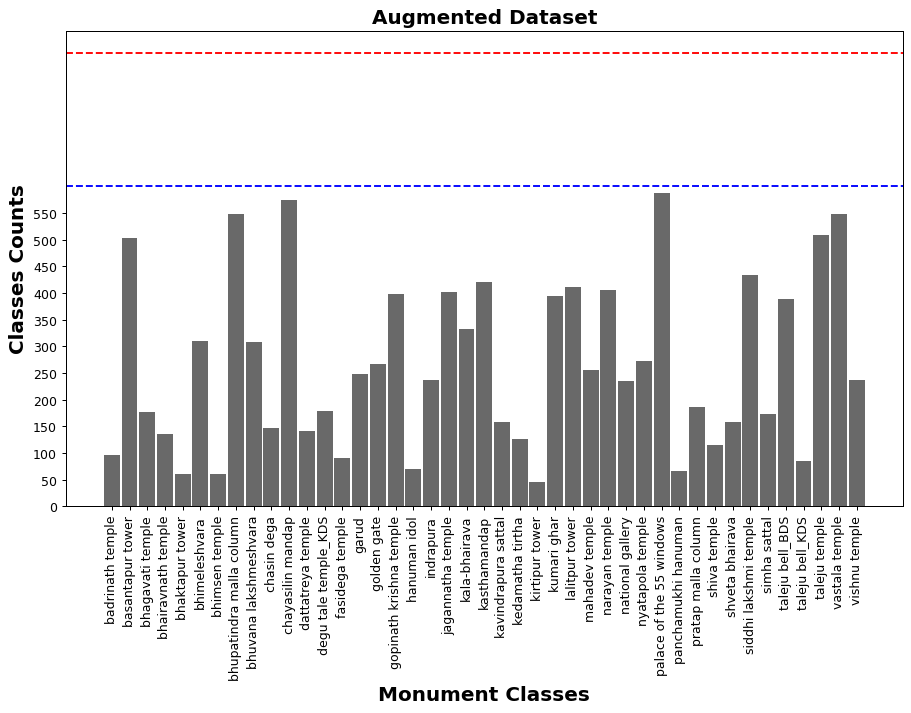

In [130]:
xml_to_bar_chart(os.path.join(ORI_BASE_DIR, annotation_path), 600)

In [114]:
ORI_ANNOTATION_PATH = os.path.join(ORI_BASE_DIR, annotation_path)
for monument_class, augmentation_list in analyze_annotations_file(os.path.join(ORI_BASE_DIR, 'Merged_Original_Augmented', annotation_path), 610, False).items():
    aug_len = len(augmentation_list)
    count = 0
    for filename in tqdm(augmentation_list):
#         random_hue_and_saturation(filename, monument_class, 3)
#         random_brightness_and_contrast(filename, monument_class, 3)
#         random_rotation(filename, monument_class, 3)
#         random_rotation(filename, monument_class)
#         multiple_orient(filename, monument_class)
        random_translation(filename, monument_class, 0)
        random_translation(filename, monument_class, 2)
#         random_translation(filename, monument_class, 3)
#         random_translation(filename, monument_class, 7)
        count += 2
        if count > 250:
            break


 43%|███████████████████████████████████▎                                              | 28/65 [00:03<00:04,  9.22it/s]

Im here


 52%|██████████████████████████████████████████▉                                       | 34/65 [00:03<00:03,  9.71it/s]

Im here
Im here
Im here


 63%|███████████████████████████████████████████████████▋                              | 41/65 [00:04<00:02,  9.83it/s]

Im here


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:07<00:00,  9.18it/s]


In [107]:
# analyze_annotations_file(os.path.join(ORI_BASE_DIR, 'Merged', annotation_path), 400, True)